In [1]:
import sys
sys.path.append('..')

In [2]:
from typing import Optional

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm.notebook import tqdm

from sklearn.cluster import KMeans

from myutils.stats import corrcoef, acfunc
from myutils.matplotlib import matplotlib_seaborn_style

from src.pca import IPCA
from src.rzd import PlacePriceModel

matplotlib_seaborn_style()

In [3]:
data = pd.read_csv('../data/data.csv', parse_dates=['date'], encoding='utf-8')

weekdays = data[['weekday', 'day_name']].drop_duplicates().sort_values(by='weekday')\
    .set_index('weekday')['day_name'].to_dict()

data.head(2)

,date,days,places,price,num,class,train,departure_timestamp,arrival_timestamp,places_frac,weekday,day_name
0,2021-04-12,1,28.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.200000,0,Monday
1,2021-04-13,1,52.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.371429,1,Tuesday


In [4]:
trains = sorted(data['train'].unique().tolist())
len(trains)

112

## Модель

$$
\begin{cases}
    n(t, \tau) = \mu(\tau) + a(t) V(\tau) + \delta(t, \tau) \\
    C(t, \tau) = b_0 + b_1 n(t, \tau) + \varepsilon(t, \tau)
\end{cases}
$$

In [5]:
maxdays = 30
n_components = 10

In [6]:
metrics = pd.read_csv('../data/model_metrics.csv')

metrics.head(2)

,num,class,explained,r2,train
0,001А,Купе,0.789427,0.177405,001А-Купе
1,002А,Купе,0.821368,0.221830,002А-Купе


Значения метрик (доля объяснённой дисперсии для PCA и коэф-т детерминации для лин. регрессии) по разным поездам.

In [7]:
def truncate_values(df: pd.DataFrame, th: float, fill_value: float = np.nan) -> pd.DataFrame:
    df = df.copy()
    df.values[np.abs(df.values) < th] = fill_value
    
    return df

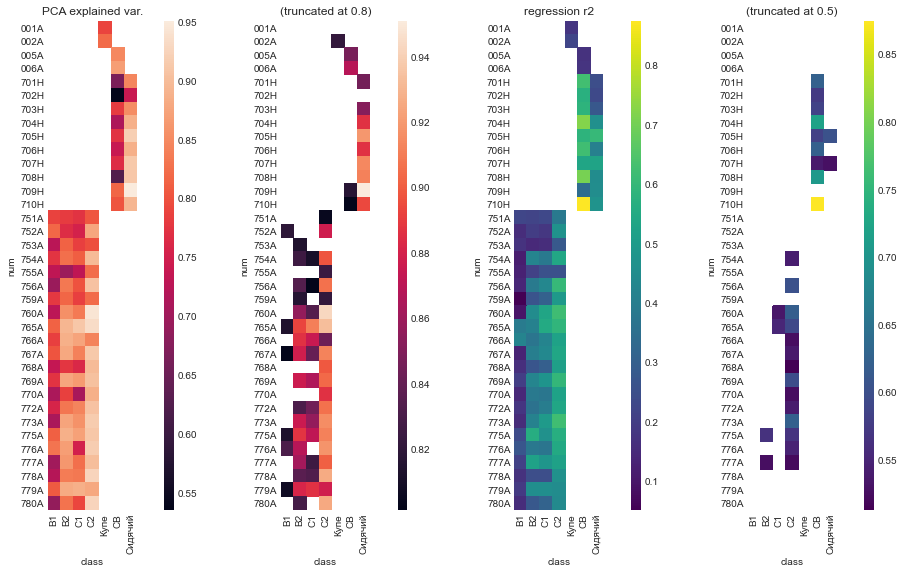

In [8]:
fig, axes = plt.subplots(ncols=4)
fig.set_size_inches(15, 9)
fig.subplots_adjust(wspace=0.7)
ax1, ax2, ax3, ax4 = axes.flatten()

explained = metrics.pivot(index='num', columns='class', values='explained')
r2 = metrics.pivot(index='num', columns='class', values='r2')

sns.heatmap(explained, ax=ax1, cbar_kws={'aspect': 50, 'pad': 0.2})
ax1.set_title('PCA explained var.')

explained = truncate_values(explained, th=0.8)

sns.heatmap(explained, ax=ax2, cbar_kws={'aspect': 50, 'pad': 0.2})
ax2.set_title('(truncated at 0.8)')

sns.heatmap(r2, ax=ax3, cmap='viridis', cbar_kws={'aspect': 50, 'pad': 0.2})
ax3.set_title('regression r2')

r2 = truncate_values(r2, th=0.5)

sns.heatmap(r2, ax=ax4, cmap='viridis', cbar_kws={'aspect': 50, 'pad': 0.2})
ax4.set_title('(truncated at 0.5)')

plt.savefig('../data/figures/model_metrics.pdf', transparent=True, bbox_inches='tight')
# plt.close()

In [9]:
class_to_color = {cl: f'C{i}' for i, cl in enumerate(data['class'].unique())}
class_to_color

{'Купе': 'C0',
 'СВ': 'C1',
 'Сидячий': 'C2',
 'B1': 'C3',
 'B2': 'C4',
 'C1': 'C5',
 'C2': 'C6'}

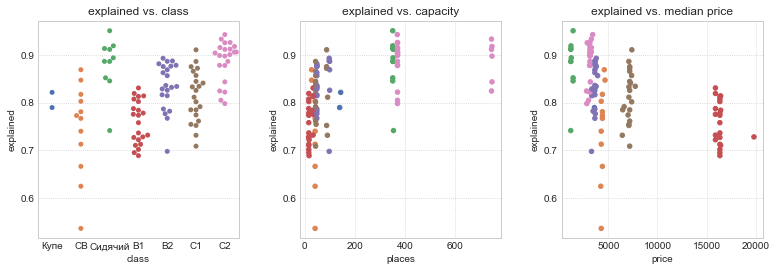

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(13, 4)
fig.subplots_adjust(wspace=0.3)

sns.swarmplot(ax=ax1, data=metrics, x='class', y='explained')
ax1.set_title('explained vs. class')

explained_vs_capacity = data.groupby('train')['places'].max().reset_index()\
    .merge(metrics[['train', 'explained']], on='train')
color = explained_vs_capacity['train'].apply(lambda x: class_to_color[x.split('-')[-1]])

explained_vs_capacity.plot(ax=ax2, kind='scatter', x='places', y='explained', color=color)

ax2.set_title('explained vs. capacity')

explained_vs_price = data.groupby('train')['price'].median().reset_index()\
    .merge(metrics[['train', 'explained']], on='train')
color = explained_vs_price['train'].apply(lambda x: class_to_color[x.split('-')[-1]])

explained_vs_price.plot(ax=ax3, kind='scatter', x='price', y='explained', color=color)

ax3.set_title('explained vs. median price')

plt.savefig('../data/figures/explaining_explained_variance.pdf', transparent=True, bbox_inches='tight')

In [11]:
explained_variance_ratio = pd.read_csv('../data/explained_variance_ratios.csv').set_index('train')
a = pd.read_csv('../data/principal_components.csv', parse_dates=['date']).set_index('date')
v = pd.read_csv('../data/eigenvectors.csv').set_index('train')
mean = pd.read_csv('../data/means.csv').set_index('train')

for df in [explained_variance_ratio, v, mean]:
    df.columns = df.columns.astype(int)

### Поезда с низкой EVR

In [12]:
mask = metrics['explained'] <= 0.7

metrics[mask]

,num,class,explained,r2,train
4,701Н,СВ,0.665765,0.624373,701Н-СВ
6,702Н,СВ,0.535258,0.574640,702Н-СВ
18,708Н,СВ,0.623968,0.707268,708Н-СВ
41,755А,B2,0.697300,0.209869,755А-B2
44,756А,B1,0.694609,0.141138,756А-B1
108,780А,B1,0.688272,0.156451,780А-B1


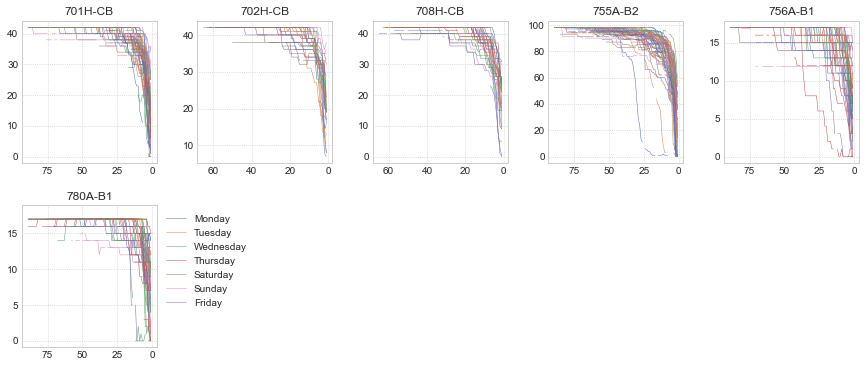

In [13]:
ncols = 5
nrows = mask.sum() // ncols + (mask.sum() % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(wspace=0.3, hspace=0.3)
axes = axes.flatten()

for train, ax in zip(metrics.loc[mask, 'train'], axes):
    train_data = data[data['train'] == train]\
        .pivot(index='date', columns='days', values='places')
    
    for date, row in train_data.iterrows():
        weekday = date.weekday()
        
        _, labels = ax.get_legend_handles_labels()
        
        label = weekdays[weekday]
        
        if label in labels:
            label = None
        
        ax.plot(row, c=f'C{weekday}', lw=0.5, label=label)
    
    ax.set_title(train)
    ax.invert_xaxis()
    
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
for i in range(mask.sum(), len(axes)):
    axes[i].axis('off')
    
plt.savefig('../data/figures/poorly_explained.pdf', transparent=True, bbox_inches='tight')

### Визуализация парной регрессии по поездам

## PCA

### $a(t)$

In [14]:
ncols = 10
nrows = a.shape[1] // ncols + (a.shape[1] % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 2.5 * nrows)
fig.subplots_adjust(wspace=0.3, hspace=0.9)
axes = axes.flatten()

for train, ax in zip(a.columns, axes):
    a[train].plot(ax=ax, c='C2', lw=1, marker='.', markersize=2)
    
    ax.set_title(train)
    ax.set_xlabel(None)

for i in range(a.shape[1], len(axes)):
    axes[i].axis('off')
    
plt.savefig('../data/figures/pcs.pdf', transparent=True, bbox_inches='tight')
plt.close()

In [15]:
ncols = 10
nrows = a.shape[1] // ncols + (a.shape[1] % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 2.5 * nrows)
fig.subplots_adjust(wspace=0.3, hspace=0.6)
axes = axes.flatten()

for train, ax in zip(a.columns, axes):
    s = a[train].copy()
    s = s.dropna()
    
    acf, crit = acfunc(s, method='spearman', maxlag=21)
    
    ax.plot(acf, lw=1)
    ax.fill_between(crit.index, crit.values, -crit.values, alpha=0.15)
    
    vmax = max(ax.get_ylim())
    ax.set_ylim(-vmax, vmax)
    
    ax.axhline(c='k', lw=0.5, ls='dashed', zorder=1)
    ax.set_title(train)

for i in range(a.shape[1], len(axes)):
    axes[i].axis('off')
    
plt.savefig('../data/figures/pcs_acf.pdf', transparent=True, bbox_inches='tight')
plt.close()

## Кластеризация по $\mu(\tau)$

In [16]:
integral_mean = (mean - mean.shift(axis=1)).drop(columns=1)

integral_mean.head(2)

,2,3,4,5,6,7,8,9,10,11,...,21,22,23,24,25,26,27,28,29,30
train,,,,,,,,,,,,,,,,,,,,,
002А-Купе,0.054047,0.042881,0.049562,0.040656,0.032875,0.027365,0.032132,0.017790,0.020611,0.011250,...,0.015713,0.011676,0.008828,0.011472,0.004928,0.00753,0.006824,0.004350,0.002948,0.004635
005А-СВ,0.052855,0.048768,0.032385,0.031166,0.027190,0.010963,0.029688,0.013643,0.027601,0.020564,...,0.014205,0.007246,0.009458,0.003999,0.010374,0.00824,0.006030,0.007472,0.022267,0.005991


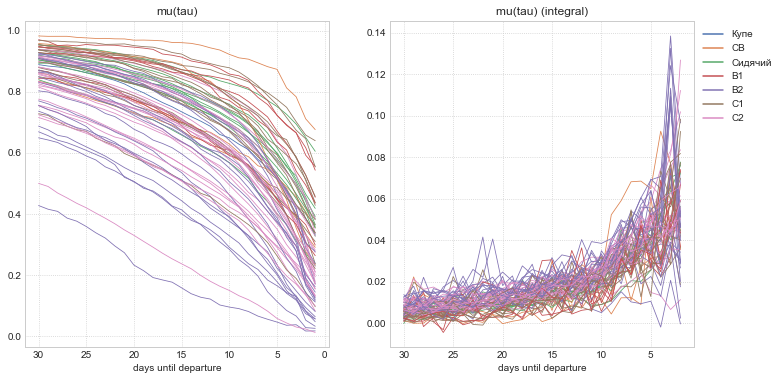

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 6)

for train in mean.index:
    color = class_to_color[train.split('-')[-1]]
    
    ax1.plot(mean.loc[train], c=color, lw=0.8)
    ax2.plot(integral_mean.loc[train], c=color, lw=0.8)

handles = []
labels = []

for cl, color in class_to_color.items():
    labels.append(cl)
    handles.append(plt.Line2D([0, 1], [0, 0], color=color))
    
ax2.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1))

for ax in [ax1, ax2]:
    ax.set_xlabel('days until departure')
    ax.invert_xaxis()

ax1.set_title('mu(tau)')
ax2.set_title('mu(tau) (integral)')

plt.savefig('../data/figures/means.pdf', transparent=True, bbox_inches='tight')

Векторы $\mu(\tau)$ по разным кластерам.

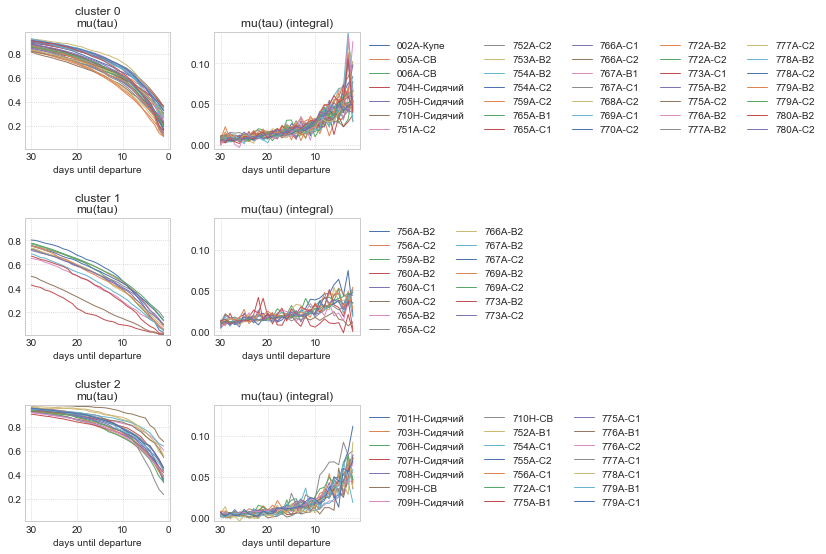

In [18]:
k = 3
kmeans = KMeans(n_clusters=k).fit(mean.values)
mu_clusters = kmeans.predict(mean.values)

ncols = 2
nrows = k

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(wspace=0.3, hspace=0.6)

mu_min = mean.min().min()
mu_max = mean.max().max()

int_mu_min = integral_mean.min().min()
int_mu_max = integral_mean.max().max()

for cluster, (ax1, ax2) in zip(np.unique(mu_clusters), axes):
    mean_i = mean.loc[mu_clusters == cluster]
    integral_mean_i = integral_mean.loc[mu_clusters == cluster]
    
    mean_i.T.plot(ax=ax1, lw=1)
    integral_mean_i.T.plot(ax=ax2, lw=1)
    
    ax1.set_title(f'cluster {cluster}\nmu(tau)')
    ax2.set_title(f'mu(tau) (integral)')
    
    ax1.set_ylim(mu_min, mu_max)
    ax2.set_ylim(int_mu_min, int_mu_max)

    ax1.legend().set_visible(False)
    ax2.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=mean_i.shape[0] // 8 + 1)
    
    for ax in [ax1, ax2]:
        ax.set_xlabel('days until departure')
        ax.invert_xaxis()

plt.savefig('../data/figures/mean_clusters.pdf', transparent=True, bbox_inches='tight')
# plt.close()

/Users/yuralytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


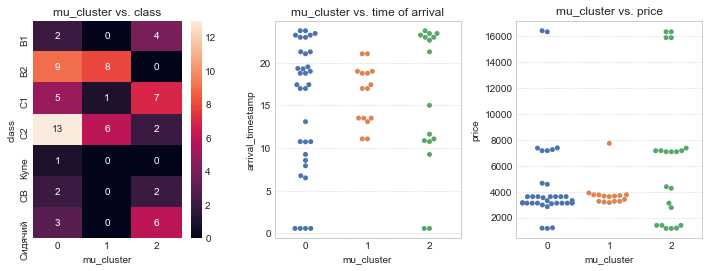

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 4)
fig.subplots_adjust(wspace=0.3)

train_class = mean.index.map(lambda x: x.split('-')[1])

sns.heatmap(pd.crosstab(mu_clusters, train_class).T, ax=ax1, annot=True)
ax1.set_xlabel('mu_cluster')
ax1.set_ylabel('class')
ax1.set_title('mu_cluster vs. class')

df = pd.Series(mu_clusters, index=mean.index, name='mu_cluster')
df.index.name = 'train'
df = df.reset_index()

df = df.merge(data[['train', 'arrival_timestamp']], on='train', how='left')\
    .drop_duplicates('train').dropna()
df = df.set_index('train')

sns.swarmplot(data=df, x='mu_cluster', y='arrival_timestamp', ax=ax2)
ax2.set_title('mu_cluster vs. time of arrival')

avg_price = data.groupby('train')['price'].median().reindex(mean.index)
df = pd.DataFrame({'mu_cluster': mu_clusters, 'price': avg_price})

sns.swarmplot(data=df, x='mu_cluster', y='price', ax=ax3)
ax3.set_title('mu_cluster vs. price')

plt.savefig('../data/figures/explaining_mean_clusters.pdf', transparent=True, bbox_inches='tight')

## Кластеризация по $V(\tau)$

In [20]:
integral_v = (v - v.shift(axis=1)).drop(columns=1)

integral_v.head(2)

,2,3,4,5,6,7,8,9,10,11,...,21,22,23,24,25,26,27,28,29,30
train,,,,,,,,,,,,,,,,,,,,,
002А-Купе,0.007571,0.001457,0.018607,0.019307,0.004958,0.011535,-0.007272,0.002577,0.005498,0.003136,...,-0.019122,-0.013141,-0.013083,-0.013410,-0.006228,-0.006098,-0.006693,-0.003381,-0.002451,-0.005887
005А-СВ,-0.002437,0.005647,0.005708,0.005728,0.010658,0.020273,-0.000378,0.002236,-0.018663,-0.000568,...,-0.010975,-0.009214,-0.013399,0.001629,-0.015235,-0.003877,-0.003785,-0.005932,-0.011443,0.000369


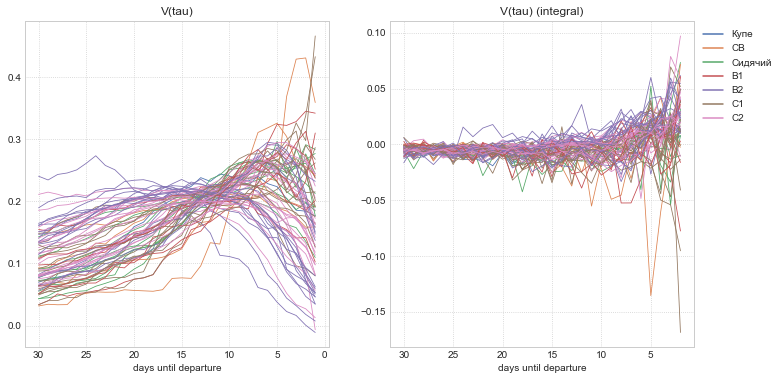

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 6)

for train in v.index:
    color = class_to_color[train.split('-')[-1]]
    
    ax1.plot(v.loc[train], c=color, lw=0.8)
    ax2.plot(integral_v.loc[train], c=color, lw=0.8)

handles = []
labels = []

for cl, color in class_to_color.items():
    labels.append(cl)
    handles.append(plt.Line2D([0, 1], [0, 0], color=color))
    
ax2.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1))

for ax in [ax1, ax2]:
    ax.set_xlabel('days until departure')
    ax.invert_xaxis()

ax1.set_title('V(tau)')
ax2.set_title('V(tau) (integral)')

plt.savefig('../data/figures/eigenvectors.pdf', transparent=True, bbox_inches='tight')

Векторы $V(\tau)$ по разным кластерам.

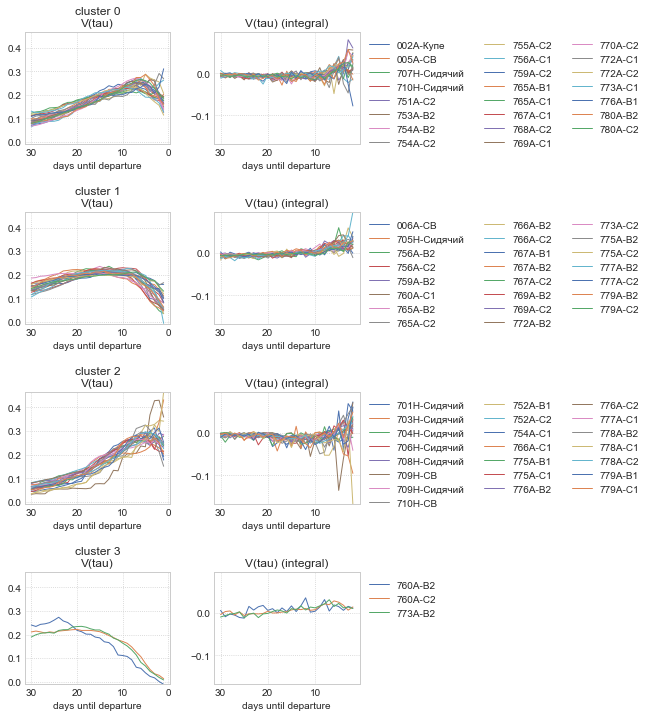

In [22]:
k = 4
kmeans = KMeans(n_clusters=k).fit(v.values)
eig_clusters = kmeans.predict(v.values)

ncols = 2
nrows = k

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(wspace=0.3, hspace=0.6)

vmin = v.min().min()
vmax = v.max().max()

int_vmin = integral_v.min().min()
int_vmax = integral_v.max().max()

for cluster, (ax1, ax2) in zip(np.unique(eig_clusters), axes):
    v_i = v.loc[eig_clusters == cluster]
    integral_v_i = integral_v.loc[eig_clusters == cluster]
    
    v_i.T.plot(ax=ax1, lw=1)
    integral_v_i.T.plot(ax=ax2, lw=1)
    
    ax1.set_title(f'cluster {cluster}\nV(tau)')
    ax2.set_title(f'V(tau) (integral)')
    
    ax1.set_ylim(vmin, vmax)
    ax2.set_ylim(int_vmin, int_vmax)

    ax1.legend().set_visible(False)
    ax2.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=v_i.shape[0] // 8 + 1)
    
    for ax in [ax1, ax2]:
        ax.set_xlabel('days until departure')
        ax.invert_xaxis()

plt.savefig('../data/figures/eigenvector_clusters.pdf', transparent=True, bbox_inches='tight')
# plt.close()

/Users/yuralytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 8.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/yuralytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 21.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


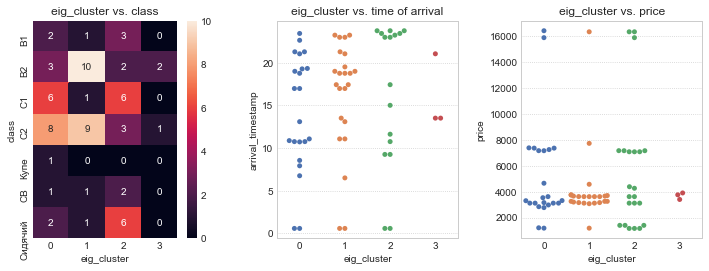

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 4)
fig.subplots_adjust(wspace=0.35)

train_class = v.index.map(lambda x: x.split('-')[1])

sns.heatmap(pd.crosstab(eig_clusters, train_class).T, ax=ax1, annot=True)
ax1.set_xlabel('eig_cluster')
ax1.set_ylabel('class')
ax1.set_title('eig_cluster vs. class')

df = pd.Series(eig_clusters, index=mean.index, name='eig_cluster')
df.index.name = 'train'
df = df.reset_index()

df = df.merge(data[['train', 'arrival_timestamp']], on='train', how='left')\
    .drop_duplicates('train').dropna()
df = df.set_index('train')

sns.swarmplot(data=df, x='eig_cluster', y='arrival_timestamp', ax=ax2)
ax2.set_title('eig_cluster vs. time of arrival')

avg_price = data.groupby('train')['price'].median().reindex(mean.index)
df = pd.DataFrame({'eig_cluster': eig_clusters, 'price': avg_price})

sns.swarmplot(data=df, x='eig_cluster', y='price', ax=ax3)
ax3.set_title('eig_cluster vs. price')

plt.savefig('../data/figures/explaining_eigenvector_clusters.pdf', transparent=True, bbox_inches='tight')

### Би-кластеризация

In [24]:
clusters = pd.DataFrame({'mu': mu_clusters, 'eig': eig_clusters}, index=v.index)
clusters['both'] = clusters['mu'].astype(str) + '-' + clusters['eig'].astype(str)

biclusters = clusters['both'].values

clusters.head(2)

,mu,eig,both
train,,,
002А-Купе,0,0,0-0
005А-СВ,0,0,0-0


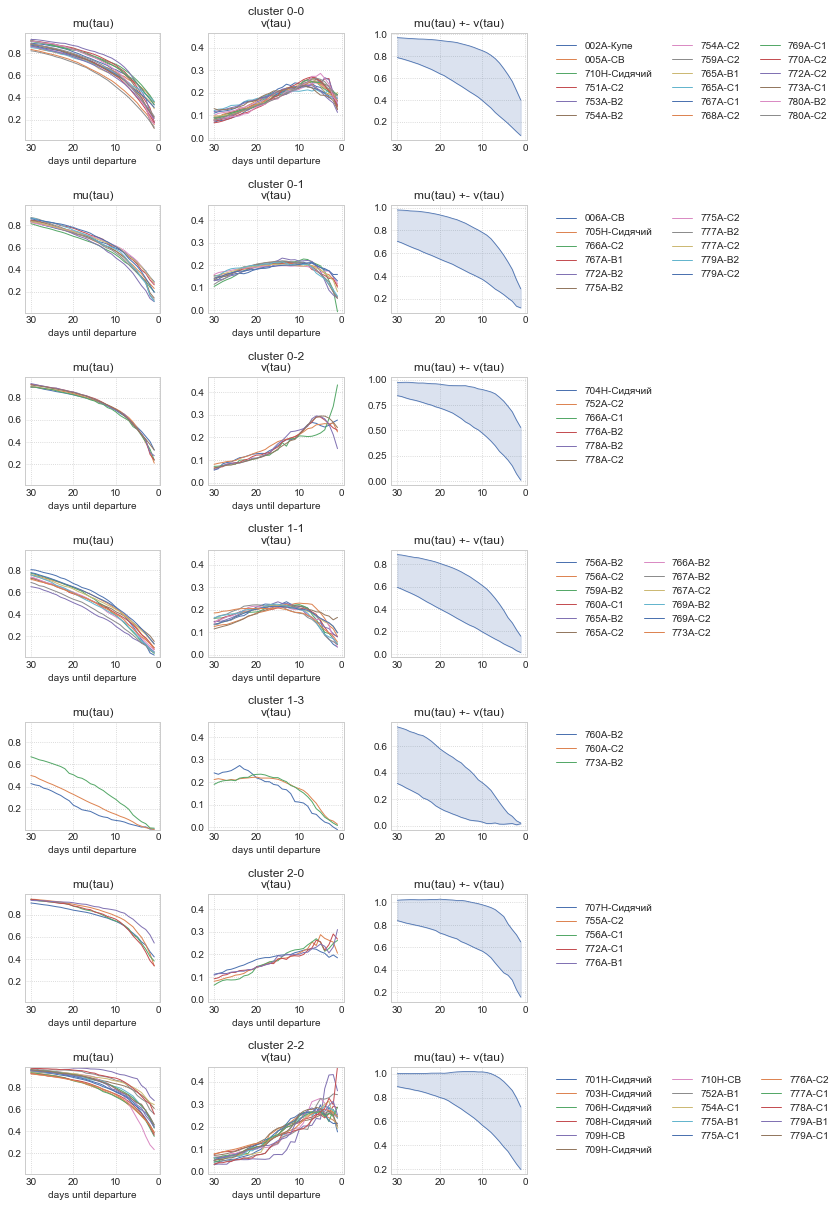

In [25]:
ncols = 3
nrows = np.unique(biclusters).size

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(hspace=0.6, wspace=0.35)

for cluster, (ax1, ax2, ax3) in zip(np.unique(biclusters), axes):
    mean_i = mean.loc[biclusters == cluster]
    
    mean_i.T.plot(ax=ax1, lw=1, legend=False)
    ax1.set_title('mu(tau)')
    ax1.set_xlabel('days until departure')
    ax1.set_ylim(mu_min, mu_max)
    
    ax1.invert_xaxis()
    
    vi = v.loc[biclusters == cluster]
    
    vi.T.plot(ax=ax2, lw=1)
    ax2.legend(loc='upper left', bbox_to_anchor=(2.5, 1), ncol=vi.shape[0] // 8 + 1)
    ax2.set_title(f'cluster {cluster}\nv(tau)')
    ax2.set_xlabel('days until departure')
    ax2.set_ylim(vmin, vmax)
    
    ax2.invert_xaxis()
    
    mean_i = mean_i.mean(axis=0)
    vi = vi.mean(axis=0)
    
    lower = mean_i - vi
    upper = mean_i + vi
    
    ax3.plot(lower, c='C0', lw=0.8)
    ax3.plot(upper, c='C0', lw=0.8)
    ax3.fill_between(mean_i.index, lower, upper, color='C0', alpha=0.2)
    ax3.set_title('mu(tau) +- v(tau)')
    ax2.set_xlabel('days until departure')
    
    ax3.invert_xaxis()

plt.savefig('../data/figures/biclusters.pdf', transparent=True, bbox_inches='tight')
# plt.close()

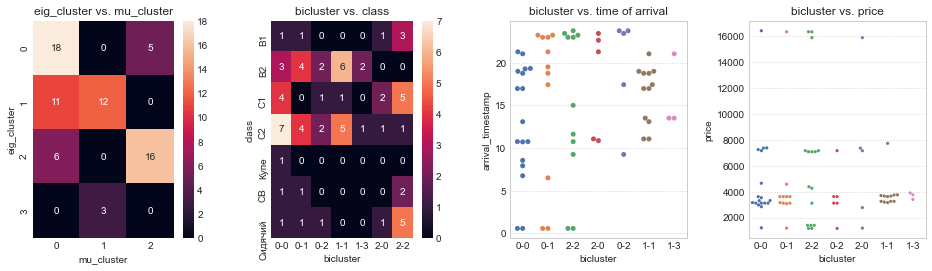

In [26]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4)
fig.set_size_inches(16, 4)
fig.subplots_adjust(wspace=0.35)

train_class = v.index.map(lambda x: x.split('-')[1])

sns.heatmap(pd.crosstab(mu_clusters, eig_clusters).T, ax=ax1, annot=True)
ax1.set_xlabel('mu_cluster')
ax1.set_ylabel('eig_cluster')
ax1.set_title('eig_cluster vs. mu_cluster')

sns.heatmap(pd.crosstab(biclusters, train_class).T, ax=ax2, annot=True)
ax2.set_xlabel('bicluster')
ax2.set_ylabel('class')
ax2.set_title('bicluster vs. class')

df = pd.Series(biclusters, index=mean.index, name='bicluster')
df.index.name = 'train'
df = df.reset_index()

df = df.merge(data[['train', 'arrival_timestamp']], on='train', how='left')\
    .drop_duplicates('train').dropna()
df = df.set_index('train')

sns.swarmplot(data=df, x='bicluster', y='arrival_timestamp', ax=ax3)
ax3.set_title('bicluster vs. time of arrival')

avg_price = data.groupby('train')['price'].median().reindex(mean.index)
df = pd.DataFrame({'bicluster': biclusters, 'price': avg_price})

sns.swarmplot(data=df, x='bicluster', y='price', ax=ax4, size=3.2)
ax4.set_title('bicluster vs. price')

plt.savefig('../data/figures/explaining_biclusters.pdf', transparent=True, bbox_inches='tight')

In [27]:
clusters.reset_index().to_csv('../data/train_clusters.csv', index=False)

In [28]:
!jupyter nbconvert --to html 2_model.ipynb

[NbConvertApp] Converting notebook 2_model.ipynb to html
[NbConvertApp] Writing 1038530 bytes to 2_model.html


Расшифровка моделей для каждого кластера.